# ***BUILDING THE MODEL FOR FACIAL EMOTION RECOGNITION***


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
!pip install --upgrade tensorflow
!pip install --upgrade keras


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 36.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 47.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 21.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 22.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 29.6 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.2.0
    Uninstalling ml-dtypes-0.2.0:
      Successfully uninstalled ml-dtypes-0.2.0
  Attempting uninstall: h5py
    Found existing installation: h5py 3.9.0
    Uninstalling h5py-3.9.0:
      Successfully uninstalled h5py-3.9.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.15.2
    Uninstalling tensorboard-2.15.2:
      Successfully uninstalled tensorboard-2.15.2
  Attempting uninstall: keras
    Fo

In [2]:
import zipfile
with zipfile.ZipFile('/content/drive/MyDrive/fer13c.zip') as zip_ref:
    zip_ref.extractall('/content/')


In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout, GlobalAveragePooling2D, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.callbacks import EarlyStopping

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

print(tf.__version__)

import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

2.16.1


# ***LOADING THE DATASET***

In [4]:

def load_dataset(root_dir):
    train_image,train_label,test_image,test_label=[],[],[],[];

    for mode in ['train', 'test']:
        mode_dir = os.path.join(root_dir, mode)
        emotions = os.listdir(mode_dir)
        for i,emotion in enumerate(emotions):
            emotion_dir = os.path.join(mode_dir, emotion)
            image_files = os.listdir(emotion_dir)

            for image_file in image_files:
                image_path = os.path.join(emotion_dir, image_file)
                image = Image.open(image_path)

                if mode=='train':
                    train_image.append(np.array(image))
                    train_label.append(emotion)
                else:
                    test_image.append(np.array(image))
                    test_label.append(emotion)


    return np.array(train_image),np.array(train_label),np.array(test_image),np.array(test_label)



In [5]:
train_images,train_labels,test_images,test_labels =load_dataset('/content/fer13c')

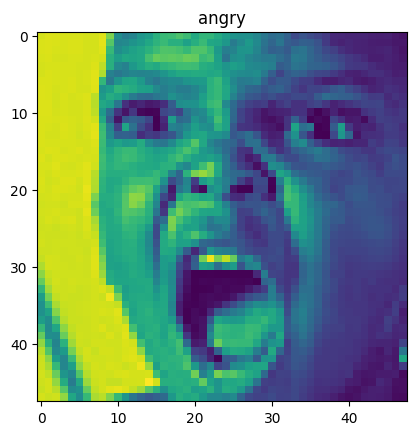

In [6]:
plt.imshow(train_images[1555])
plt.title(train_labels[1555])
plt.axis('on')
plt.show()

# ***SHUFFLING THE IMAGES AND DISPLAYING SAMPLES***

In [7]:
import random

c1 = list(zip(train_images, train_labels))
random.shuffle(c1)

train_images, train_labels = zip(*c1)

train_images = np.array(train_images)
train_labels = np.array(train_labels)

c2=list(zip(test_images,test_labels))
random.shuffle(c2)

test_images,test_labels =zip(*c2)

test_images=np.array(test_images)
test_labels=np.array(test_labels)

In [8]:
train_images=train_images/255;
test_images=test_images/255;

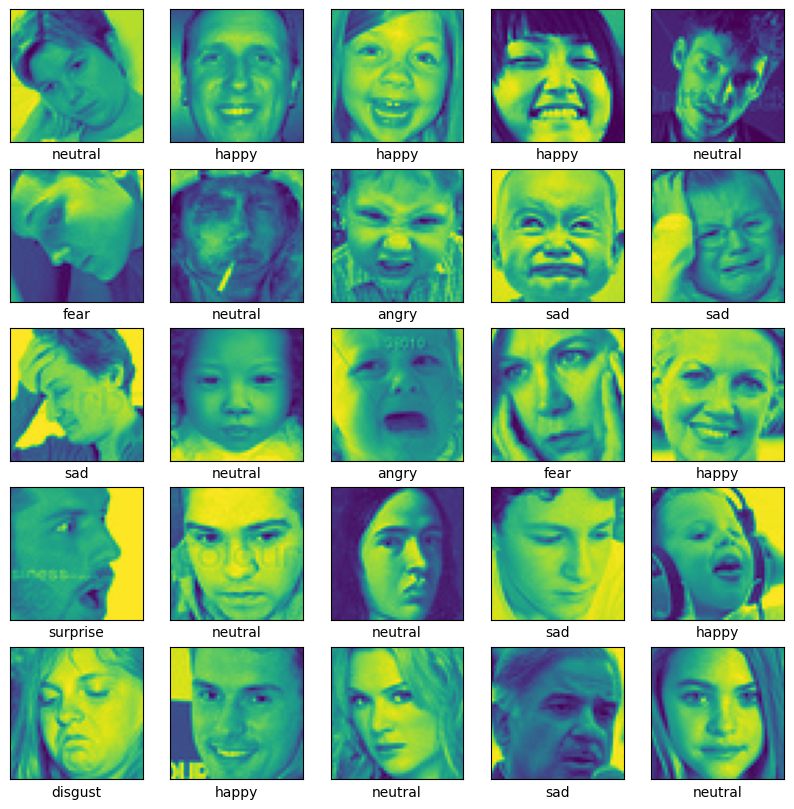

In [9]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i])
    plt.xlabel(train_labels[i])
plt.show()


In [10]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

# Convert labels to one-hot encoding
label_encoder = LabelEncoder()
train_labels_encoded = to_categorical(label_encoder.fit_transform(train_labels))
test_labels_encoded = to_categorical(label_encoder.transform(test_labels))


In [11]:
import numpy as np

train_images = np.expand_dims(train_images, axis=-1)
test_images = np.expand_dims(test_images, axis=-1)

print("Train images shape:", train_images.shape)
print("Test images shape:", test_images.shape)


Train images shape: (26865, 48, 48, 1)
Test images shape: (9099, 48, 48, 1)


In [12]:
# Data augmentation
from imgaug import augmenters as iaa

datagen = ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1,
    fill_mode='nearest',

)


train_generator = datagen.flow(train_images, train_labels_encoded, batch_size=32)
test_generator = datagen.flow(test_images, test_labels_encoded, batch_size=32)


# ***DEFINING THE MODEL***

In [13]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, regularizers
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.layers import Activation, Dropout, Flatten, Dense, LeakyReLU
from tensorflow.keras.preprocessing.image import ImageDataGenerator

model = models.Sequential()

# 1st CNN layer
model.add(Conv2D(64, (3, 3), input_shape=(48, 48, 1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 2nd CNN layer
model.add(Conv2D(128, (5, 5)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 3rd CNN layer
model.add(Conv2D(512, (3, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(512, (2, 2)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))


model.add(Flatten())

# Fully connected 1st layer
model.add(Dense(128))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(0.25))

# Fully connected layer 2nd layer
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(0.25))

model.add(Dense(7, activation='softmax'))


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


# ***COMPILING AND BUILDING THE MODEL***

In [14]:
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam, SGD, RMSprop

model.compile(optimizer=Adam(learning_rate=0.001), loss=keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])




In [27]:

history = model.fit(train_images,train_labels_encoded,
                    epochs=48,
                    validation_data=(test_images,test_labels_encoded))

Epoch 1/48
840/840 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.9392 - loss: 0.1776 - val_accuracy: 0.7969 - val_loss: 0.9375
Epoch 2/48
840/840 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.9403 - loss: 0.1758 - val_accuracy: 0.7998 - val_loss: 0.8940
Epoch 3/48
840/840 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.9414 - loss: 0.1651 - val_accuracy: 0.7968 - val_loss: 0.9259
Epoch 4/48
840/840 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.9397 - loss: 0.1743 - val_accuracy: 0.7985 - val_loss: 0.8757
Epoch 5/48
840/840 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - accuracy: 0.9442 - loss: 0.1613 - val_accuracy: 0.7964 - val_loss: 0.9163
Epoch 6/48
840/840 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.9427 - loss: 0.1631 - val_accuracy: 0.7662 - val_loss: 1.0290
Epoch 7/48
840/840 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.9412 - loss: 0.1738 - val_accuracy: 0.7970 - val_loss: 0.9207
Epoch 8/48
840/840 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.9413 - loss: 0.1730 - 

In [28]:
test_l,test_acc=model.evaluate(test_images,test_labels_encoded,verbose=2)
print('Accuracy:',test_acc)

285/285 - 2s - 7ms/step - accuracy: 0.8002 - loss: 0.9516
Accuracy: 0.8001978397369385


# ***TESTING BY PLOTTING THE SAMPLES***

In [19]:
pred=model.predict(test_images)


285/285 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


In [20]:

classes=['angry','disgust','fear','happy','neutral','sad','surprise']

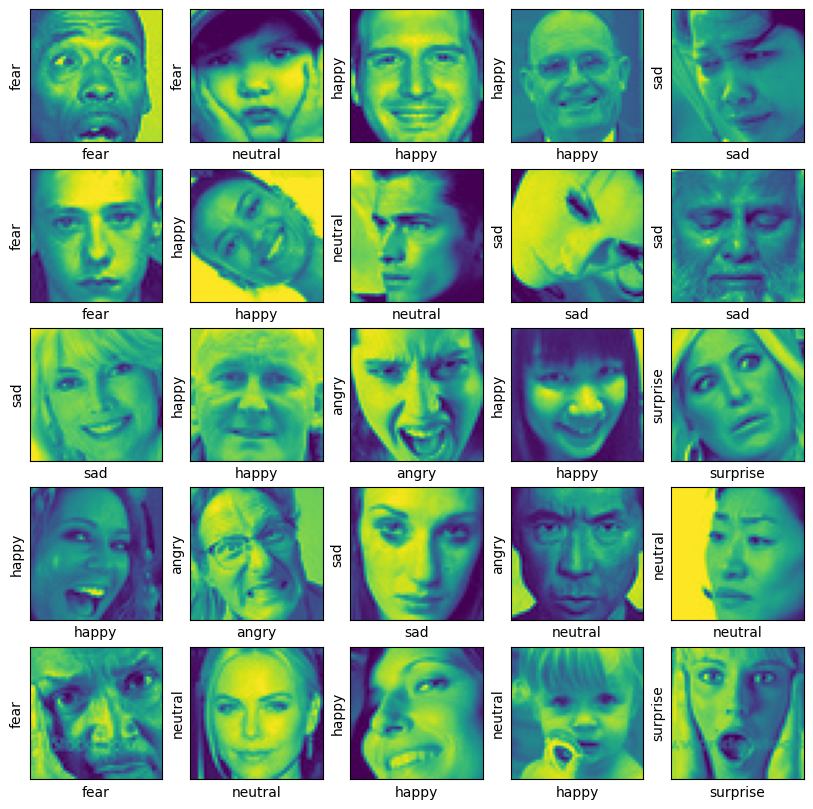

In [24]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(test_images[i+1000])
    plt.xlabel(classes[np.argmax(pred[i+1000])])
    plt.ylabel(test_labels[i+1000])

plt.show()


In [25]:
from tensorflow.keras.models import save_model
#downloading the model
model.save('fer13c.keras')
save_model(model, 'fer13c.h5')


In [ ]:
!cp /content/fer.keras /content/drive/MyColabModels


cp: cannot create regular file '/content/drive/MyColabModels': Operation not supported
